In [136]:
library(tidyverse)
library(stringr)
library(repr)

# Proposal Group 17: Title....

Lua Presidio, Daniel Hou, Michelle Yan

Data credit: 

## Introdution

somethign something


## Preliminary exploratory data analysis

In [118]:
# url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00368/"
# download.file(url, "Facebook_metrics.zip")
# unzip(fb_zip)
# fb_data <- read_csv("dataset_Facebook.csv") 
# fb_data
col_names_proper = c("Page_total_likes", "Type", "Category", "Post_month", "Post_weekday", "Post_hour", "Paid", 
                     "Lifetime_Post_Total_Reach", "Lifetime_Post_Total_Impressions", "Lifetime_Engaged_Users", 
                     "Lifetime_Post_Consumers", "Lifetime_Post_Consumptions", "Lifetime_Post_Impressions_by_people_who_have_liked_your_Page", 
                     "Lifetime_Post_reach_by_people_who_like_your_Page", "Lifetime_People_who_have_liked_Page_and_engaged_with_post",
                     "comment","like", "share", "Total_Interactions")
# full data
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip",temp)
fb_data <- read_csv2(unz(temp, "dataset_Facebook.csv"))
colnames(fb_data) <- col_names_proper
unlink(temp)
fb_data

# training data
set.seed(10)
fb_data_2 <- fb_data %>%
    sample_n(25)
fb_data_2

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  `Page total likes` = col_double(),
  Type = col_character(),
  Category = col_double(),
  `Post Month` = col_double(),
  `Post Weekday` = col_double(),
  `Post Hour` = col_double(),
  Paid = col_double(),
  `Lifetime Post Total Reach` = col_double(),
  `Lifetime Post Total Impressions` = col_double(),
  `Lifetime Engaged Users` = col_double(),
  `Lifetime Post Consumers` = col_double(),
  `Lifetime Post Consumptions` = col_double(),
  `Lifetime Post Impressions by people who have liked your Page` = col_double(),
  `Lifetime Post reach by people who like your Page` = col_double(),
  `Lifetime People who have liked your Page and engaged with your post` = col_double(),
  comment = col_double(),
  like = col_double(),
  share = col_double(),
  `Total Interactions` = col_double()
)



Page_total_likes,Type,Category,Post_month,Post_weekday,Post_hour,Paid,Lifetime_Post_Total_Reach,Lifetime_Post_Total_Impressions,Lifetime_Engaged_Users,Lifetime_Post_Consumers,Lifetime_Post_Consumptions,Lifetime_Post_Impressions_by_people_who_have_liked_your_Page,Lifetime_Post_reach_by_people_who_like_your_Page,Lifetime_People_who_have_liked_Page_and_engaged_with_post,comment,like,share,Total_Interactions
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
139441,Photo,2,12,2,3,0,7244,13594,671,410,580,6228,3200,396,19,325,49,393
139441,Status,2,12,1,9,0,10472,20849,1191,1073,1389,16034,7852,1016,1,152,33,186
139441,Photo,3,12,1,3,1,11692,19479,481,265,364,15432,9328,379,3,249,27,279
139441,Photo,3,12,7,9,1,13720,24137,537,232,305,19728,11056,422,0,325,14,339
139441,Status,2,12,7,3,0,11844,22538,1530,1407,1692,15220,7912,1250,0,161,31,192


Page_total_likes,Type,Category,Post_month,Post_weekday,Post_hour,Paid,Lifetime_Post_Total_Reach,Lifetime_Post_Total_Impressions,Lifetime_Engaged_Users,Lifetime_Post_Consumers,Lifetime_Post_Consumptions,Lifetime_Post_Impressions_by_people_who_have_liked_your_Page,Lifetime_Post_reach_by_people_who_like_your_Page,Lifetime_People_who_have_liked_Page_and_engaged_with_post,comment,like,share,Total_Interactions
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
85979,Photo,3,1,6,11,0,5280,8703,951,911,1237,5757,3300,431,1,79,30,110
136393,Link,1,10,5,10,0,4664,9463,204,182,251,7196,3324,173,0,32,16,48
120050,Photo,3,5,4,4,1,4032,7278,684,607,848,4935,2644,432,7,139,34,180
115368,Photo,3,4,2,2,1,5594,9586,739,670,1048,5732,3256,555,12,138,39,189
92614,Photo,2,2,2,3,1,5290,9100,1053,994,1326,6285,3578,441,2,129,32,163
98195,Link,2,3,6,6,0,5730,10083,103,71,97,8964,4830,92,2,32,15,49
137893,Video,1,11,5,3,1,100768,220447,2101,1735,2331,59658,18880,885,17,449,84,550
100732,Photo,1,3,6,10,0,122944,457509,1373,1268,2106,72846,13184,475,0,136,13,149
102112,Photo,1,3,1,19,0,238,570,143,142,834,567,236,99,0,2,0,2


In [138]:
# finding the mean of post interactions, engagement, impressions, reach for paid and unpaid posts, etc., 
# and number of observations for each status of Paid vs unpaid, and post type
# subject to change based on specifics of proposal question
fb_data_3 <- fb_data_2 %>%
    mutate(isPaid = case_when (
            Paid == 1 ~ "PAID", 
            Paid == 0 ~ "NOT PAID")) %>%
    group_by(isPaid, Type) %>%
    summarize(number_of_observations = n(),
              Lifetime_Post_Total_Reach_avg = mean(Lifetime_Post_Total_Reach),
              Lifetime_Post_Total_Impressions_avg = mean(Lifetime_Post_Total_Impressions),
              Lifetime_Engaged_Users_avg = mean(Lifetime_Engaged_Users),
              Lifetime_Post_Consumers_avg = mean(Lifetime_Post_Consumers),
              Lifetime_Post_Consumptions_avg = mean(Lifetime_Post_Consumptions),
              Lifetime_Post_Impressions_by_people_who_liked_Page_avg = mean(Lifetime_Post_Impressions_by_people_who_have_liked_your_Page),
              Lifetime_Post_reach_by_people_who_like_your_Page = mean(Lifetime_Post_reach_by_people_who_like_your_Page),
              Lifetime_People_who_liked_Page_and_engaged_with_post_avg = mean(Lifetime_People_who_have_liked_Page_and_engaged_with_post),
              comment_avg = mean(comment),
              like_avg = mean(like),
              share_avg = mean(share),
              Total_Interactions_avg = mean(Total_Interactions))
fb_data_3



`summarise()` regrouping output by 'isPaid' (override with `.groups` argument)



isPaid,Type,number_of_observations,Lifetime_Post_Total_Reach_avg,Lifetime_Post_Total_Impressions_avg,Lifetime_Engaged_Users_avg,Lifetime_Post_Consumers_avg,Lifetime_Post_Consumptions_avg,Lifetime_Post_Impressions_by_people_who_liked_Page_avg,Lifetime_Post_reach_by_people_who_like_your_Page,Lifetime_People_who_liked_Page_and_engaged_with_post_avg,comment_avg,like_avg,share_avg,Total_Interactions_avg
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NOT PAID,Link,3,5756.667,10143.67,196.3333,166.0000,228.3333,8521.00,4635.333,174.6667,1.333333,44.0000,15.33333,60.66667
NOT PAID,Photo,12,13888.333,44499.42,602.3333,533.3333,847.2500,10279.67,3434.583,329.5000,3.250000,109.8333,24.33333,137.41667
NOT PAID,Status,1,13872.000,27468.00,2664.0000,2570.0000,3395.0000,20198.00,10432.000,2252.0000,4.000000,217.0000,50.00000,271.00000
PAID,Photo,7,18108.286,29915.29,1126.0000,912.5714,1408.7143,19543.43,10276.571,729.5714,6.428571,295.2857,39.14286,340.85714
PAID,Status,1,31136.000,59964.00,6164.0000,5934.0000,9237.0000,35977.00,18048.000,4376.0000,60.000000,859.0000,90.00000,1009.00000
PAID,Video,1,100768.000,220447.00,2101.0000,1735.0000,2331.0000,59658.00,18880.000,885.0000,17.000000,449.0000,84.00000,550.00000


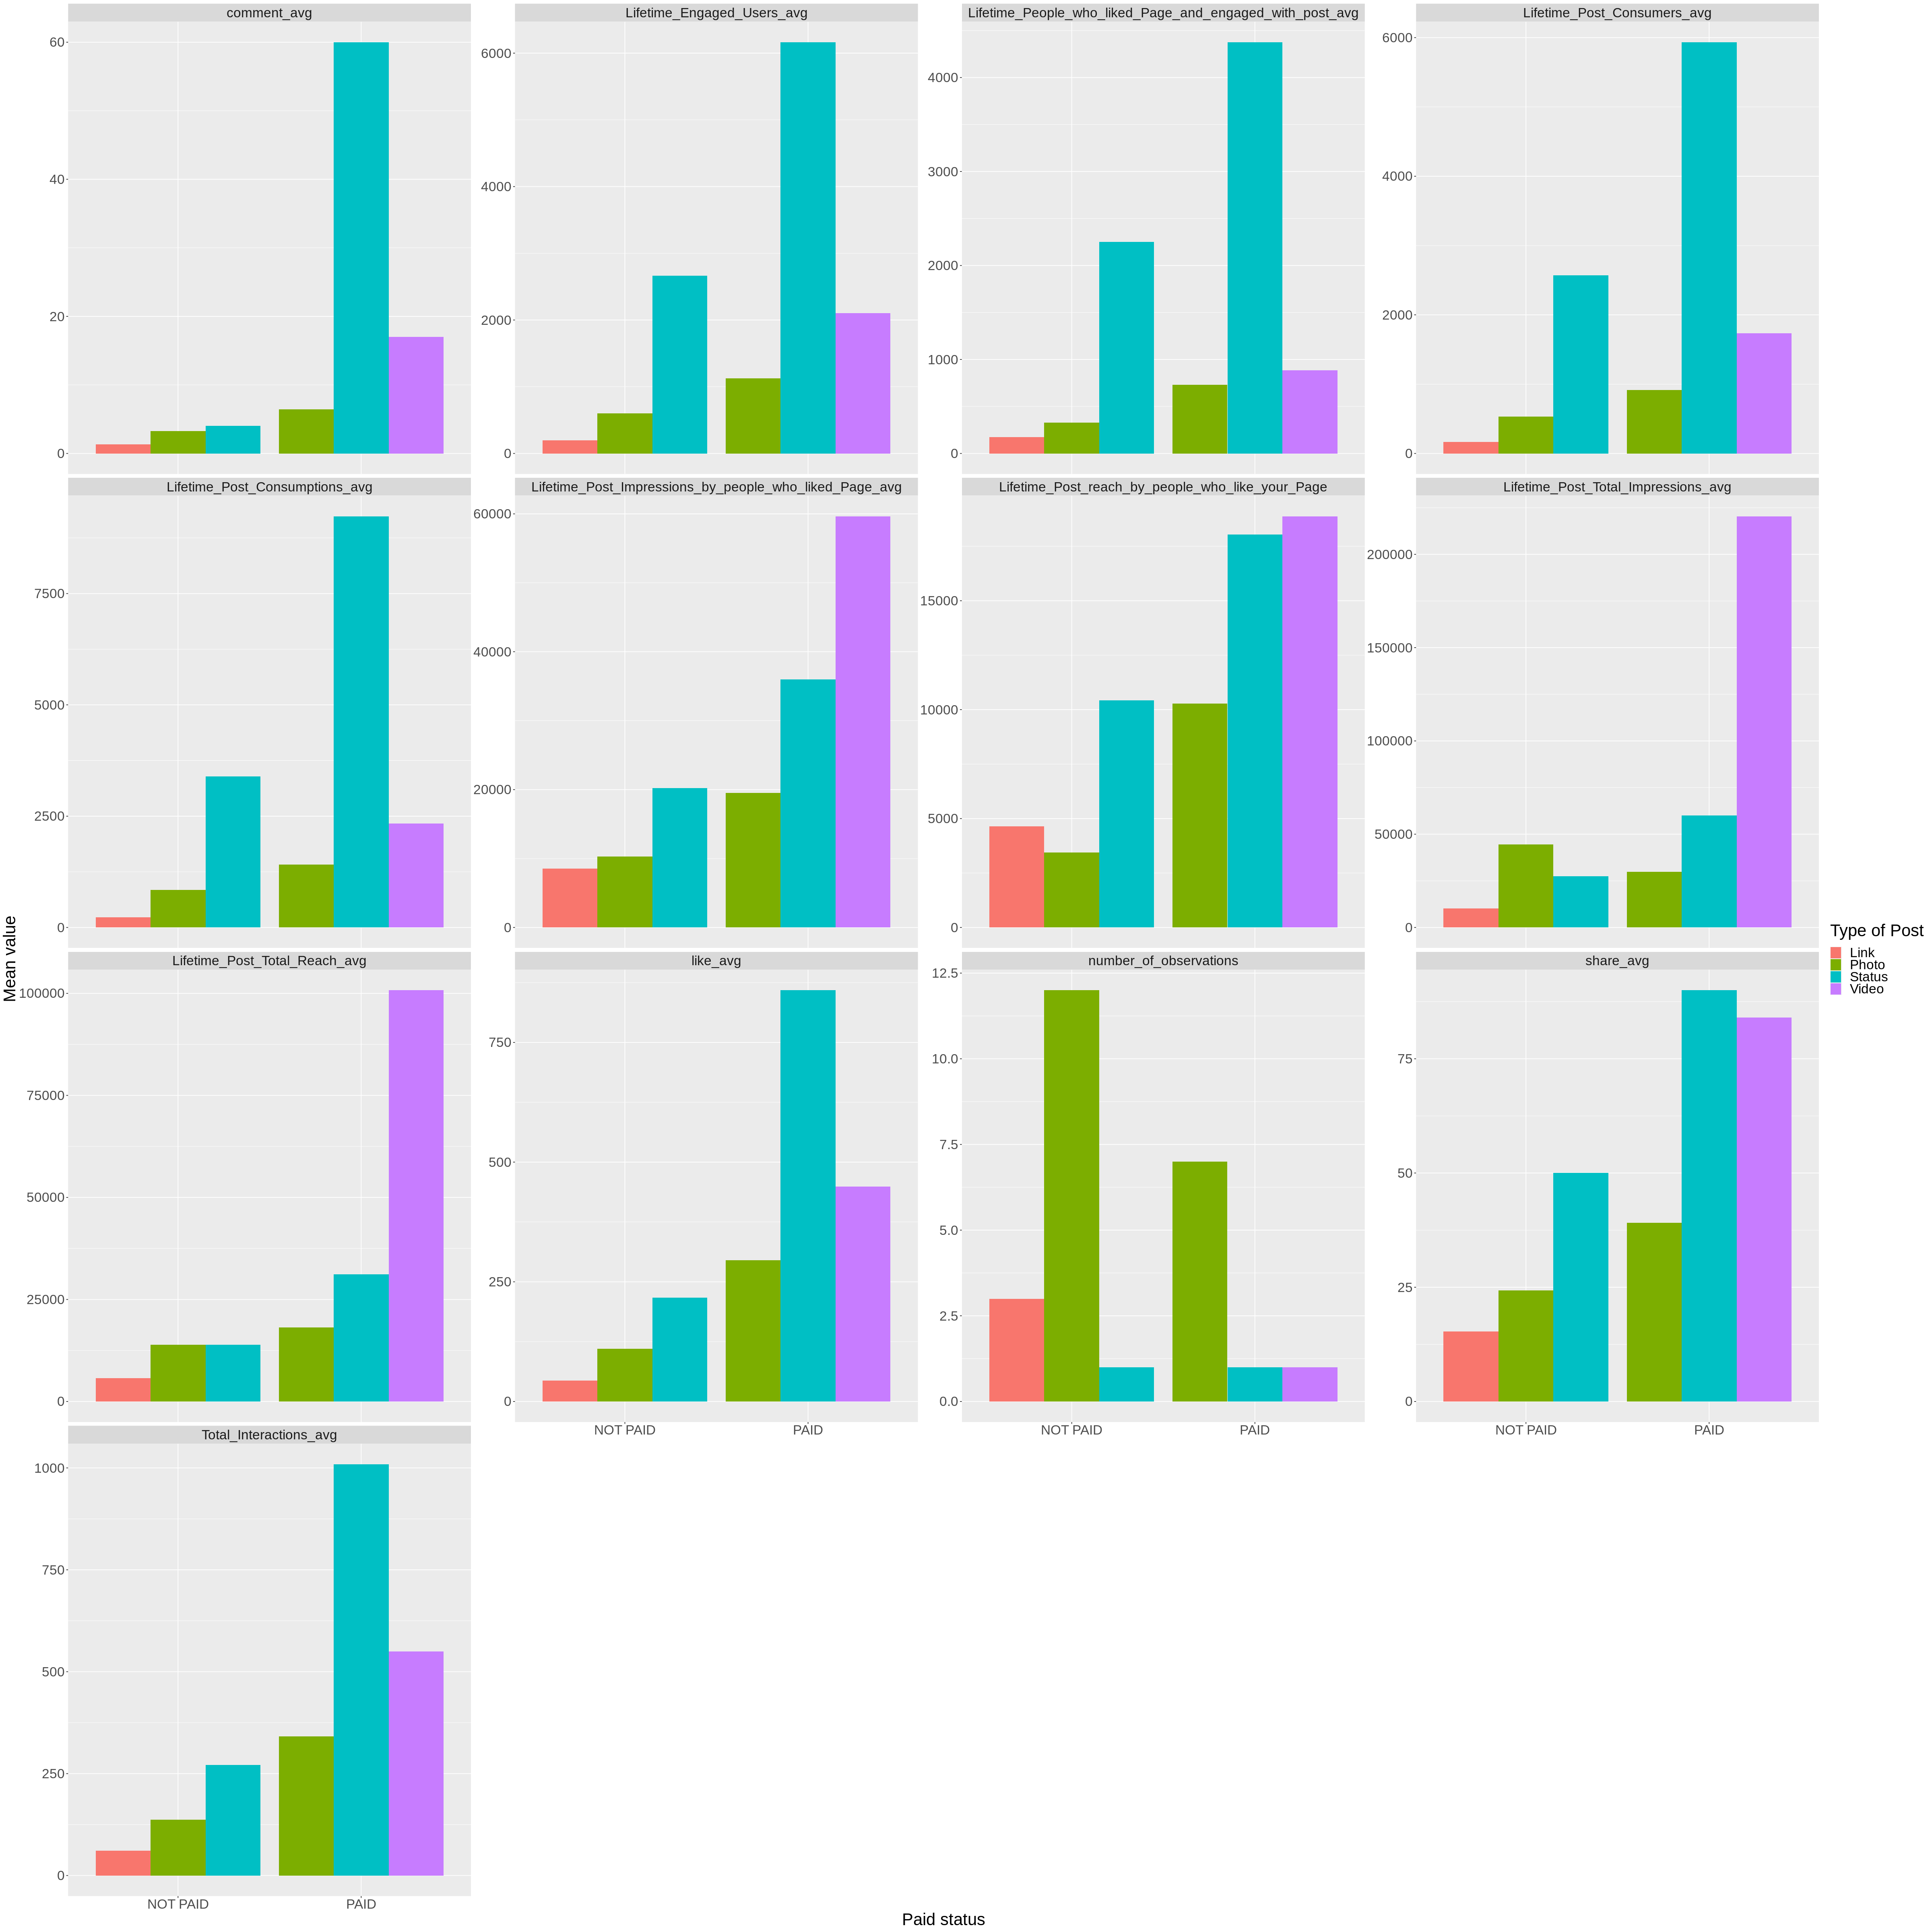

In [145]:
#preliminary visualization of each of the means based on Paid status and Type
options(repr.plot.height = 40, repr.plot.width = 40)
fb_data_3 %>%
    pivot_longer(col = number_of_observations:Total_Interactions_avg,
                names_to = "variable",
                values_to = "value") %>%
    ggplot(aes(x = isPaid, y= value, fill = Type)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_wrap(~ variable, scales = "free_y", ncol = 4)+
    xlab("Paid status") +
    ylab("Mean value") +
    labs(fill = "Type of Post") +
    theme(text = element_text(size = 25))

In [121]:
## Methods